In [4]:
# Just imports
import sympy
import sympy.vector
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


In [5]:

# Just some defenitions
x, y, z = sympy.symbols('x y z')
R = sympy.vector.CoordSys3D('R')
def my_eval(vec, x, y, z):
    return vec.evalf(subs={R.x:x, R.y:y, R.z:z})

# Define object function and constraints
obj_func = R.x*R.y + R.y + 0*R.z
# We are one the form constrain >= 0
constraints = [
    2-R.x**2-R.y**2,
    R.y,
    sympy.exp(R.x+R.y)-1
]

# Get gradients of constraint
constraints_grad = [sympy.vector.gradient(con, doit=True) for con in constraints]

# Work with the constraints
constraints_f = [sympy.lambdify([R.x, R.y], con >= 0) for con in constraints]

obj_grad = sympy.vector.gradient(obj_func, doit=True)
#print(my_eval(obj_grad, 0, 1, 0).components)

# Function for making level curves
c = sympy.Symbol('c')
y_func = sympy.solve(obj_func-c, R.y)[0]
y_f = sympy.lambdify([R.x, c], y_func)


interactive(children=(FloatSlider(value=1.0, description='k', max=5.0, min=-3.0), FloatSlider(value=1.0, descr…

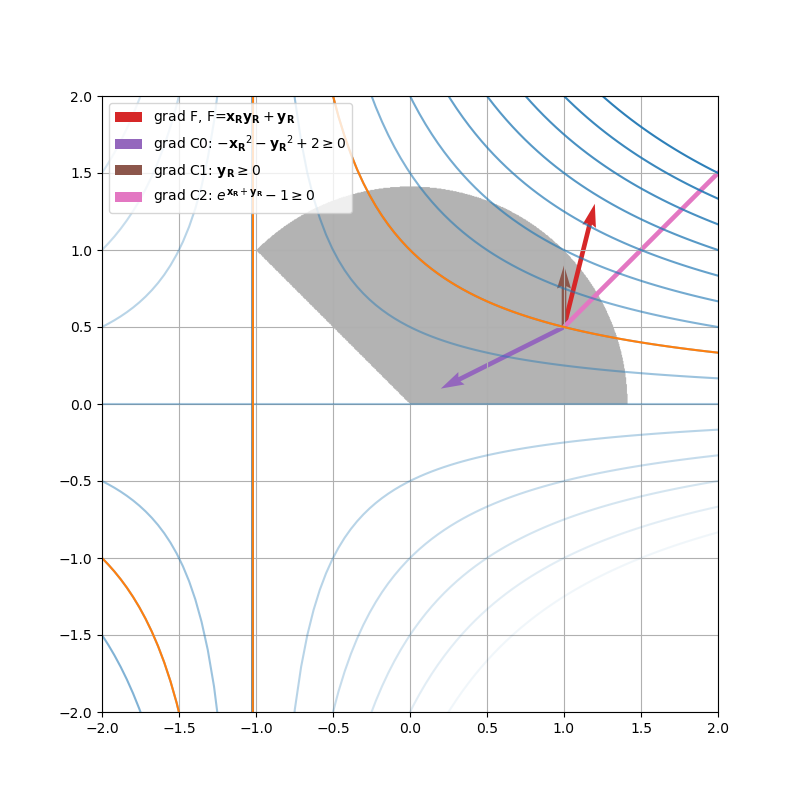

In [6]:
# set up plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_ylim([-4, 4])
ax.grid(True)
 
# Set intervals
x_interval = [-2, 2, 100/(2*np.pi)]
levels_interval = (-3, 5, 0.5)
vect_magnifier = 5

# Set feasable region
d = np.linspace(x_interval[0],x_interval[1],900)
x_feas, y_feas = np.meshgrid(d,d)
feas_reg = constraints_f[0](x_feas, y_feas)
for con in constraints_f[1:]:
    feas_reg = (feas_reg & con(x_feas, y_feas))
feas_reg = feas_reg.astype(int)

#print(np.vstack([feas_reg.argmax(axis=0), np.arange(len(feas_reg[0]))]).T[feas_reg.sum(0) > 0])

x_points = np.linspace(x_interval[0], x_interval[1], 100)

class ColorOrg:
    
    def __init__(self, init_val=0):
        self.id = init_val - 1
        
    def get_color(self):
        self.id += 1
        return 'C'+str(self.id)
 
@widgets.interact(k=(levels_interval[0], levels_interval[1], 0.1), 
                  x_pos=(x_interval[0], x_interval[1], 0.1),
                  mag=(0, 0.2, 0.005))
def update(k=1, x_pos=1, mag=0.1):
    """Remove old lines from plot and plot new one"""
    
    color_org = ColorOrg(3) # For organizing colors
    mag = max(mag, 0.005)
    ax.cla()
    legends = []
    #[l.remove() for l in ax.lines]
    try:
        y_pos = y_f(x_pos, k)
    except:
        y_pos = 0
    
    
    print(f"f({x_pos}, {y_pos})={k}")
    
    try:
        # Show gradient of objective function
        obj_comps = defaultdict(lambda: 0, my_eval(obj_grad, x_pos, y_pos, 0).components)
        objx_length, objy_length = np.float32(obj_comps[R.i]), np.float32(obj_comps[R.j])
        ax.quiver(np.float32(x_pos), np.float32(y_pos), objx_length, objy_length, scale=1/mag, color=color_org.get_color()) # x_pos, y_pos, x_length, y_length
        legends.append(f"grad F, F=${sympy.latex(obj_func)}$")
        
        # Show gradient of constraints
        for i, g in enumerate(constraints_grad):
            g_comps = defaultdict(lambda: 0, my_eval(g, x_pos, y_pos, 0).components)
            gx_length, gy_length = np.float32(g_comps[R.i]), np.float32(g_comps[R.j])
            ax.quiver(np.float32(x_pos), np.float32(y_pos), gx_length, gy_length, scale=1/mag, color=color_org.get_color())
            legends.append(f"grad C{i}: ${sympy.latex(constraints[i]>=0)}$")
            
    except Exception as e:
        print(e)
    
    for i, l in enumerate(np.arange(*levels_interval)):
        a = i*levels_interval[2]/(levels_interval[1]-levels_interval[0])
        ax.plot(x_points, y_f(x_points, l), color='C0', alpha=a)
        
    ax.plot(x_points, y_f(x_points, k), color='C1')
    ax.imshow(feas_reg, extent=(x_feas.min(),x_feas.max(),y_feas.min(),y_feas.max()),origin="lower", cmap="Greys", alpha = 0.3)
    
    ax.legend(legends)
    
    ax.grid()
    